In [25]:
from datasets import load_dataset
import json
from pathlib import Path


### Préparation du IMBD dataset

In [50]:
dataset = load_dataset("imdb")
subset = dataset["train"].shuffle(seed=42).select(range(100)) # Shuffle pour équilibrer les classes

labels = set(item["label"] for item in subset)
print(f"Labels présents dans le dataset : {labels}")

data = {
    "prompt": "The review says: \"{TEXT}\"\nThe sentiment expressed is: {LABEL}",
    "verbalizer": {
        "1": ["positive", "enjoyed", "liked", "good"],
        "0": ["negative", "disliked", "not enjoy", "bad"]
    },
    "samples": []
}

for item in subset:
    text = item["text"].replace("\n", " ").strip()
    label = str(item["label"])  # 0 = négatif, 1 = positif
    data["samples"].append({"text": text, "label": label})

# Sauvegarde
Path("../prompts").mkdir(exist_ok=True)
with open("../prompts/imdb_prompt2_label.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=2)

print("Fichier prompts/imdb.json créé avec succès.")


Labels présents dans le dataset : {0, 1}
Fichier prompts/imdb.json créé avec succès.


### Préparation du dataset AG News

In [56]:
dataset = load_dataset("ag_news")  
subset = dataset["train"].shuffle(seed=42).select(range(100))

label_names = dataset["train"].features["label"].names
label_map = {str(i): label_names[i] for i in range(len(label_names))}
print(f"Labels présents dans le dataset : {label_map}")

data = {
    "prompt": "Classify the data with these topics: World, Sports, Business, or Sci/Tech.",
    "verbalizer": {
        "0": ["world"],
        "1": ["sports"],
        "2": ["business"],
        "3": ["sci", "tech", "sci/tech", "sci tech", "science", "technology"]
    },
    "samples": []
}


for item in subset:
    text = item["text"].replace("\n", " ")
    label = str(item["label"])
    data["samples"].append({"text": text, "label": label})

# Sauvegarde
Path("../prompts").mkdir(exist_ok=True)
with open("../prompts/agnews_prompt2_decoding.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=2)

print("Fichier prompts/bbcnews.json créé avec succès.")


Labels présents dans le dataset : {'0': 'World', '1': 'Sports', '2': 'Business', '3': 'Sci/Tech'}
Fichier prompts/bbcnews.json créé avec succès.


### Visualisation des résultats

  dataset   prompt   scoring  accuracy  f1_score
0  agnews  prompt2     label  0.530000  0.480594
1  agnews  prompt1  decoding  0.260000  0.107302
2    imdb  prompt2     label  0.670000  0.620690
3  agnews  prompt2  decoding  0.795918  0.778942
4  agnews  prompt1     label  0.440000  0.432575
5    imdb  prompt1     label  0.550000  0.347826
6    imdb  prompt1  decoding  0.936842  0.928571
7    imdb  prompt2  decoding  0.927083  0.913580


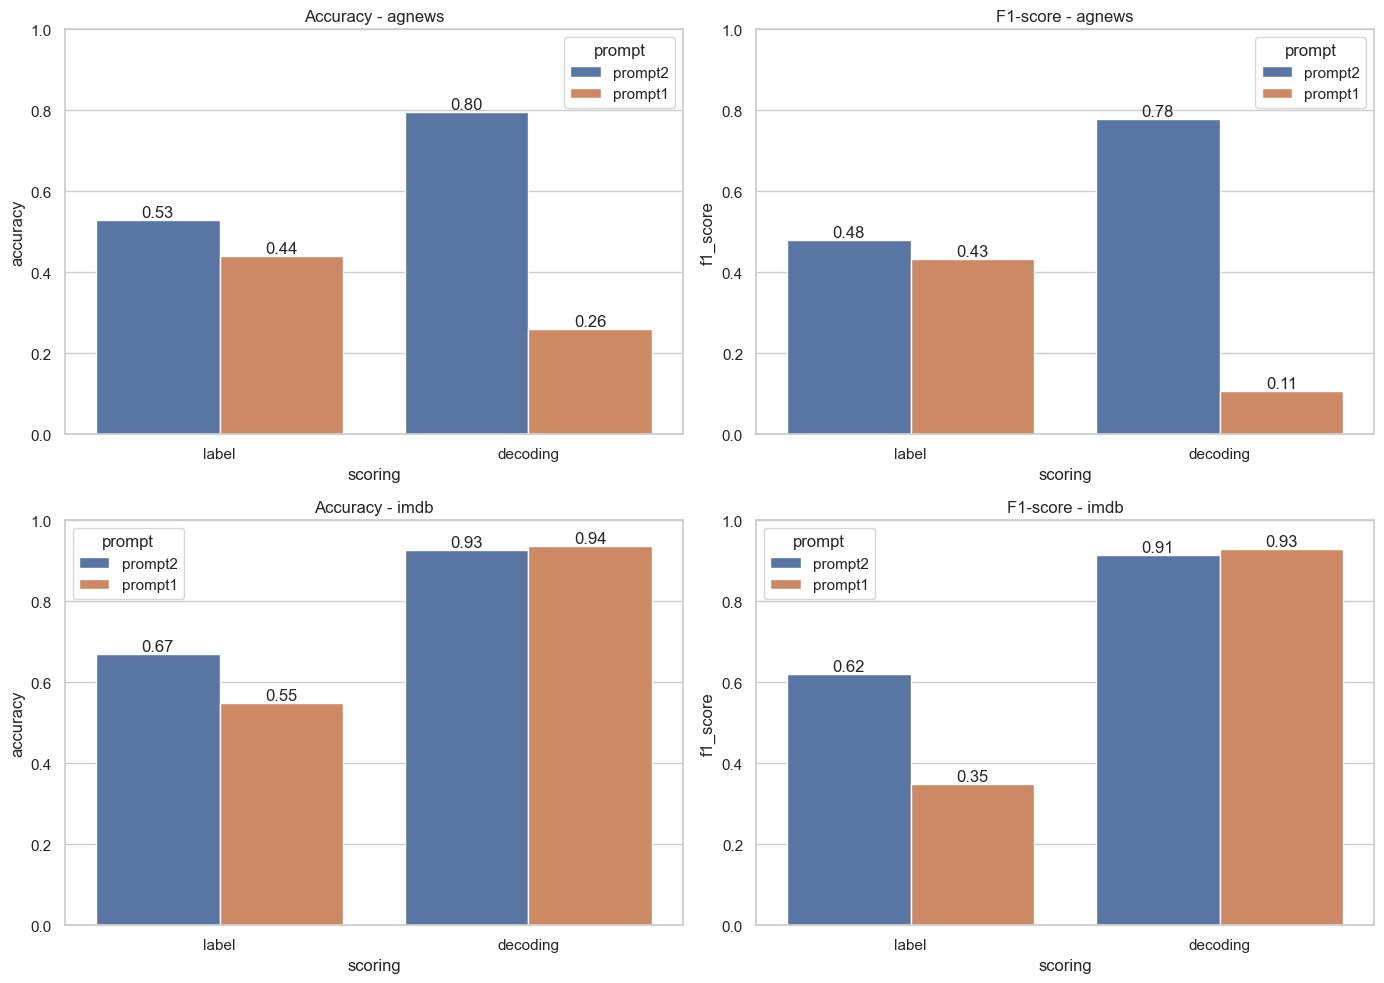

In [ ]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Dossier contenant les résultats
results_dir = "../results"
rows = []

# Parcours des fichiers JSON
for filename in os.listdir(results_dir):
    if filename.endswith(".json"):
        path = os.path.join(results_dir, filename)
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)

        prompt_name = Path(filename).stem 
        parts = prompt_name.split("_")
        dataset = parts[0]
        prompt = parts[1]
        scoring = parts[2] if len(parts) > 2 else "unknown"

        accuracy = data.get("accuracy")
        f1_score = data.get("f1")

        rows.append({
            "dataset": dataset,
            "prompt": prompt,
            "scoring": scoring,
            "accuracy": accuracy,
            "f1_score": f1_score
        })

# DataFrame
df = pd.DataFrame(rows)
print(df)

# Configuration 
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
datasets = df['dataset'].unique()

for i, dataset in enumerate(datasets):
    data_subset = df[df['dataset'] == dataset]

    # Accuracy
    ax1 = axes[i][0]
    sns.barplot(data=data_subset, x="scoring", y="accuracy", hue="prompt", ax=ax1)
    ax1.set_title(f"Accuracy - {dataset}")
    ax1.set_ylim(0, 1)
    ax1.bar_label(ax1.containers[0], fmt='%.2f')
    ax1.bar_label(ax1.containers[1], fmt='%.2f')

    # F1-score
    ax2 = axes[i][1]
    sns.barplot(data=data_subset, x="scoring", y="f1_score", hue="prompt", ax=ax2)
    ax2.set_title(f"F1-score - {dataset}")
    ax2.set_ylim(0, 1)
    ax2.bar_label(ax2.containers[0], fmt='%.2f')
    ax2.bar_label(ax2.containers[1], fmt='%.2f')

plt.tight_layout()


# Sauvegarde 
output_path = "../results/summary_plot.png"
plt.savefig(output_path)
plt.show()
